In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os

from presentation.scripts.contrast_curve import get_clean_cube, \
                                get_fakecomp_to_inject, \
                                get_throughput, load_folder

%load_ext autoreload
%autoreload 2

2023-08-02 15:11:28.724176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 15:11:29.249620: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://

In [8]:
cube, psfs, angles = load_folder(data_folder='./data/real/f_dhtau/')
psfs = psfs[0] # get the first wavelength

From the NEGFC routine we obtain the params table which contain the optimal values for the companion parameters

In [9]:
table = pd.read_csv('./logs/f_dhtau/prediction.csv')
table = table[table['snr'] > 10]
table

,index,x,y,flux,fwhm_mean,snr,optimal_flux,optimal_x,optimal_y
0,0,384.839338,366.860187,278.385232,4.127939,68.267050,341.631073,384.83353,366.86010
1,1,385.998693,727.507117,128.015363,4.261339,80.891019,150.828735,386.00287,727.51200
4,4,548.480908,731.764102,1.652026,4.809203,19.143805,2.114843,548.47766,731.76886


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-02 15:13:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
`subi_size` is odd (while frame size is even)
Setting `subi_size` to 8 pixels
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.086259
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
`Force_odd` is True and frame size is even, therefore new frame size was set to 63
Flux in 1xFWHM aperture: 0.893
Flux in 1xFWHM aperture: 0.934
Flux in 1xFWHM aperture: 1.107
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-02 15:13:03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done

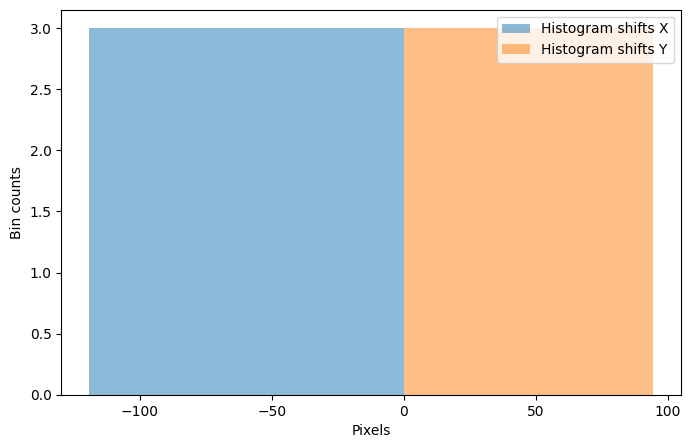

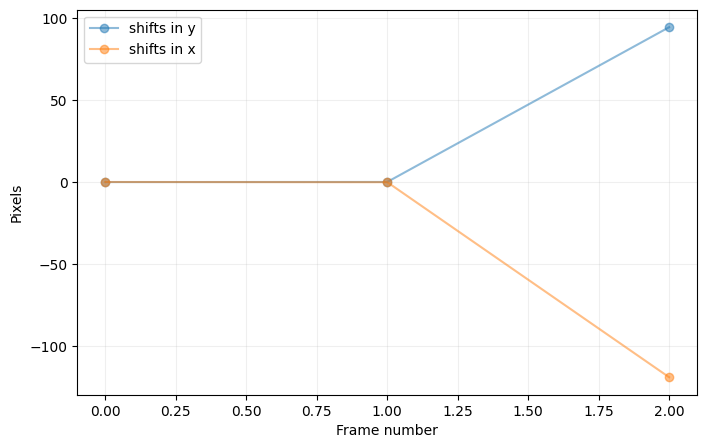

In [12]:
cube_adi, empty_adi, psf_norm = get_clean_cube(cube, 
                                               psfs, 
                                               angles,
                                               params_table=table)

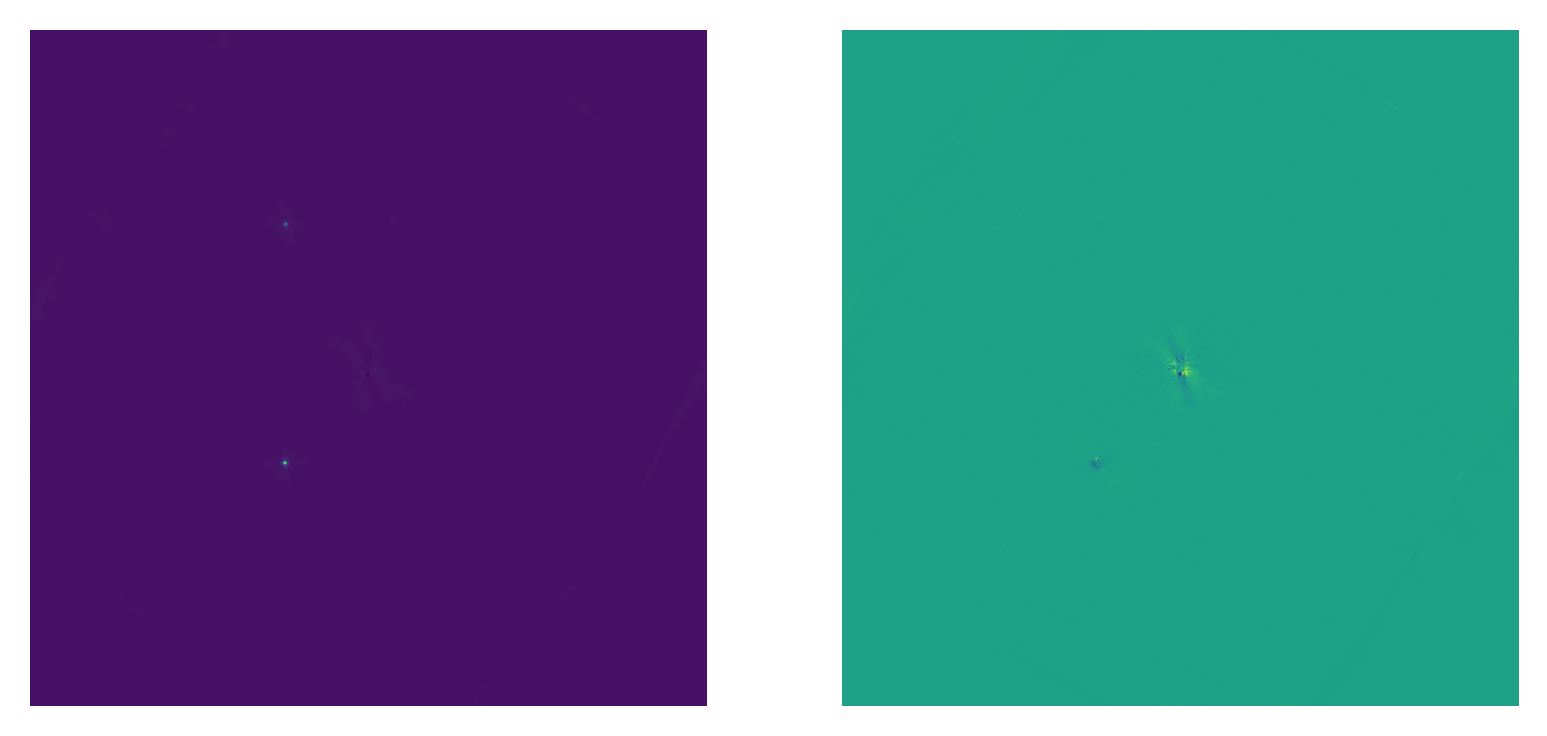

In [78]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, dpi=300)

axes[0].imshow(cube_adi, origin='lower') 
               #,vmin=cube_adi.min(), vmax=cube_adi.max())
axes[0].axis('off')
axes[1].imshow(empty_adi, origin='lower') 
               #,vmin=cube_adi.min(), vmax=cube_adi.max())
axes[1].axis('off')
plt.show()

In [81]:
x_fake_comp, y_fake_comp, \
flux_fake_comp, frame_squares = get_fakecomp_to_inject(
                             residuals_frame=empty_adi, 
                             params_table=table,
                             offset=9)

In [82]:
empty_adi.shape

(1023, 1023)

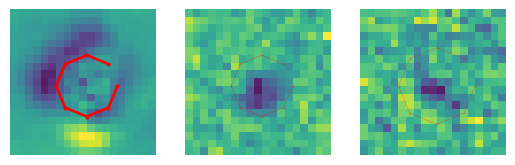

In [92]:
n_comp = len(flux_fake_comp)
fig, axes = plt.subplots(1, n_comp, sharex=True, sharey=True)
for i in range(n_comp):
    axes[i].imshow(frame_squares[i], alpha=0.9)
    w = frame_squares[i].shape[0]/2
    
    axes[i].plot(x_fake_comp[i]+w, y_fake_comp[i]+w, marker='o', 
                 markersize=flux_fake_comp[i][0], 
                 linewidth=flux_fake_comp[i][0], color='r')
    axes[i].axis('off')

In [103]:
table

,index,x,y,flux,fwhm_mean,snr,optimal_flux,optimal_x,optimal_y
0,0,384.839338,366.860187,278.385232,4.127939,68.267050,341.631073,384.83353,366.86010
1,1,385.998693,727.507117,128.015363,4.261339,80.891019,150.828735,386.00287,727.51200
4,4,548.480908,731.764102,1.652026,4.809203,19.143805,2.114843,548.47766,731.76886


In [166]:
t, xpp, ypp,rfc = get_throughput(x_fake_comp, 
                   y_fake_comp, 
                   flux_fake_comp,
                   psf=psf_norm[0],
                   cube=cube, 
                   rot_angles=angles,
                   params_table=table)

In [167]:
from vip_hci.preproc.derotation import cube_derotate
drcube = cube_derotate(cube, angles, 
                       imlib='opencv', 
                       interpolation='nearneig')

rfc

192.56886655984752

192.56886655984752
192.56886655984752
192.56886655984752
192.56886655984752
192.56886655984752
192.56886655984752
192.56886655984752
192.56886655984752


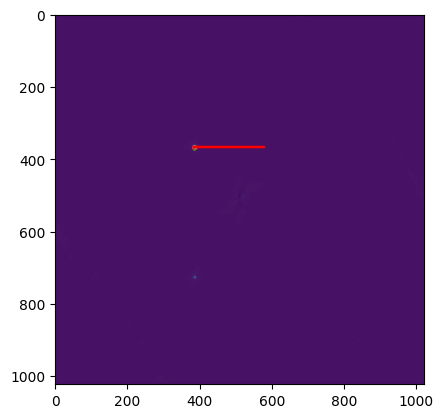

In [168]:
plt.figure(dpi=100)
for xx, yy in zip(xpp, ypp):
    plt.imshow(cube_adi)
    plt.scatter(xx, yy, s=1)
    r = rfc
    print(r)
    plt.plot([table.iloc[0]['optimal_x'], table.iloc[0]['optimal_x']+r], 
             [table.iloc[0]['optimal_y'], table.iloc[0]['optimal_y']], color='r')
#     plt.xlim(370, 400)
#     plt.ylim(350, 380)
#     plt.axis('off')

In [62]:
aper = CircularAperture((single_npsf[0].shape[0]//2, single_npsf[0].shape[0]//2), 
                        r=mean_fwhm_fit/2.) 
starphot_estimated = aperture_photometry(single_npsf, aper, method='exact')
starphot_estimated = starphot_estimated['aperture_sum'][0]

In [ ]:
cc_1 = contrast_curve(cube, 
                      rot_angles, 
                      psf_norm, 
                      fwhm=row['fwhm_mean'], 
                      pxscale=0.01225, 
                      starphot=starphot_estimated,
                      sigma=5, 
                      nbranch=1, 
                      algo=pca_annular,
                      radius_int=int(row['fwhm_mean']),
                      ncomp=9, 
                      debug=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 16:27:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca_annular, FWHM = 4.261339461993815, # BRANCHES = 1, SIGMA = 5, STARPHOT = 0.9999999207732931
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
